## Coupling metric: Mixing Diagrams 
<b>Author:</b> Meg Fowler <br>
<b>Date:</b> 11 Sep 2020 <br>
<br>
<b>Short description:</b> Mixing diagrams are helpful for quantifying heat and moisture entrainment fluxes at the top of the PBL. This script will be modeled closely after A.B. Tawfik's Fortran script 'mixing_diagram.f90', which is distributed as part of his CoMeT package. The only major difference here is that it's been re-written to Python. 

In [144]:
# Import libraries 
import comet as cm
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 
import time 
import regionmask
import geopy.distance

# Plotting utils 
import matplotlib.pyplot as plt 
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util


## Read in data 
Required input: 
* 2m Temperature 
* 2m specific humidity 
* Surface pressure 
* PBL height 
* Sensible heat flux 
* Latent heat flux 
<br><br>
Should also have soil moisture at near-surface

In [2]:
# Define data dir and file names 
dataDir = '/Users/meganfowler/Documents/NCAR/Analysis/Coupling_initial/data/hrSim_CONUS/'

atmFile = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.cam.h1.1979-1981_hrVars-CONUS.nc'
smFile  = dataDir+'f.e21.FHIST_BGC.f09_f09_mg17.hourlyOutput.001.clm2.h1.1979-1981_hrSoilWater10-CONUS.nc'

# Set variable names for each input 
T2m_name  = 'TREFHT'
Q2m_name  = 'QREFHT'
PS_name   = 'PS'
PBLH_name = 'PBLH'
SH_name   = 'SHFLX'
LH_name   = 'LHFLX'
SM_name   = 'SOILWATER_10CM'

# Input lat/lon of interest 
#  ( Set to central location of ARM SGP site for now )
latVal = 36.66     
lonVal = -97.29 


In [98]:
# Open datasets
atm_df = xr.open_dataset(atmFile, decode_times=True)
atm_df['time'] = atm_df.indexes['time'].to_datetimeindex()

lnd_df = xr.open_dataset(smFile,  decode_times=True)


<ipython-input-98-eba54f5ea7b7>:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  atm_df['time'] = atm_df.indexes['time'].to_datetimeindex()


## Pick out location first

In [99]:
# Isolate lat and lon arrays from df
latArr = atm_df.lat.values
lonArr = atm_df.lon.values

# Convert longitude if entered in -180-180 format 
if ((max(lonArr)>180) & (lonVal<0)): 
    lonVal = lonVal % 360

## Assuming that lat and lon saved in model output is the gridcell center 
##   ( true for CESM history files )
## Find gridcell containing that point 

# First get model resolution for gridcell spacing 
modelRes_lat = latArr[1]-latArr[0]
modelRes_lon = lonArr[1]-lonArr[0]
print('Model resolution (lat x lon) is found to be: %.2f x %.2f\n' % (modelRes_lat, modelRes_lon))

# First pass at getting closest value - find lat/lon within 1 gridcell of requested data point 
possibleLat = np.where( (latArr>=latVal-modelRes_lat) & (latArr<=latVal+modelRes_lat))[0]
possibleLon = np.where( (lonArr>=lonVal-modelRes_lon) & (lonArr<=lonVal+modelRes_lon)) [0]

# Now figure out distance between gridcell center and requested value 
for iLat in range(len(possibleLat)):
    for iLon in range(len(possibleLon)):
        # Get coordinates of gridcell center 
        coord2 = [latArr[possibleLat[iLat]], lonArr[possibleLon[iLon]]]
        
        # Compute geodesic distance between grid center and point requested 
        dist = geopy.distance.distance([latVal,lonVal], coord2).km 
        
        # print('At [%i, %i], distance is %.2f km' % (iLat, iLon, dist))  # If you want to see the distances computed 
        
        if ((iLat==0) & (iLon==0)):
            distMin = dist
            selLat  = iLat
            selLon  = iLon
        elif dist < distMin:
            distMin = dist
            selLat = iLat 
            selLon = iLon 
        
print('Closest point found is [%.2f, %.2f], %.3f km away from requested point of [%.2f, %.2f]\n' % 
      (latArr[possibleLat[selLat]], lonArr[possibleLon[selLon]], distMin, latVal, lonVal))

## Now hang on to the indices of the closest-matching lat and lon values 
iLat = possibleLat[selLat]
iLon = possibleLon[selLon]
            

Model resolution (lat x lon) is found to be: 0.94 x 1.25

Closest point found is [36.28, 262.50], 45.902 km away from requested point of [36.66, 262.71]



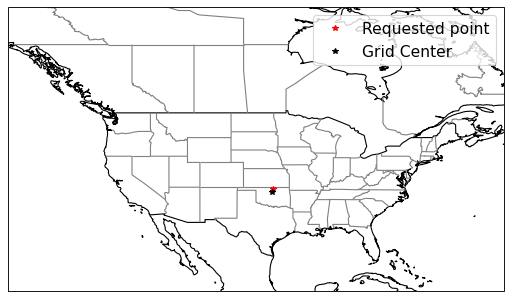

In [100]:
# Plot map of point and gridcell center... 
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
ax.set_extent([np.min(lonArr-360), np.max(lonArr-360),np.min(latArr), np.max(latArr)])

ax.coastlines() 
ax.add_feature(cfeature.BORDERS,edgecolor='k')
# Set up to add states to plots
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces,edgecolor='gray')
    
ax.plot(lonVal,latVal,'r*',markersize=5,transform=ccrs.PlateCarree())   # Point for sanity check
ax.plot(lonArr[iLon], latArr[iLat], 'k*', markersize=5, transform=ccrs.PlateCarree())

ax.legend(['Requested point', 'Grid Center'],fontsize=14)
plt.show()

In [101]:
# Extract just the point from the datasets 
atm_df_sel = atm_df.isel(lat=iLat, lon=iLon)
lnd_df_sel = lnd_df.isel(lat=iLat, lon=iLon)


(4018.0, 4437.756249999999)

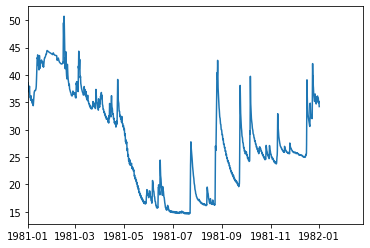

In [215]:
# To be able to easily access years, months, days - use Pandas 
dates    = pd.DatetimeIndex(atm_df_sel['time'].values)

plt.plot(dates, lnd_df_sel[SM_name].values)
plt.xlim(datetime.date(1981,1,1))


## This part is unique to what I'm doing; will need to generalize

In [230]:
# # Let's look at just June...
# UTC_mon = atm_df_sel['UTC_mon'].values
# iMon    = np.where(UTC_mon==6)[0]

# atm_df_selJune = atm_df_sel.isel(time=iMon)
# lnd_df_selJune = lnd_df_sel.isel(time=iMon)

# Going to pick out some random day in that period...
yrChoice  = 1981
monChoice = 5
dayChoice = 1

iSel = np.where((atm_df_sel.UTC_day.values==dayChoice) & (atm_df_sel.UTC_mon==monChoice) & (atm_df_sel.UTC_yr.values==yrChoice))[0]

atm_df_selMon = atm_df_sel.isel(time=iSel)
lnd_df_selMon = lnd_df_sel.isel(time=iSel)


In [231]:
# For Oklahoma, 7a-7p is 12 UTC - 00 UTC 
iHrs = np.where(atm_df_selMon.UTC_hr.values>=12)[0]

atm_df_selMon_daytime = atm_df_selMon.isel(time=iHrs)
lnd_df_selMon_daytime = lnd_df_selMon.isel(time=iHrs)


In [232]:
# Convert to energy units for 2mT and 2mQ 

Lv = 2.5e6  # Latent heat of vaporization
Cp = 1005.7 # Specific heat capacity 

T2m_energy = atm_df_selMon_daytime[T2m_name].values * Cp
Q2m_energy = atm_df_selMon_daytime[Q2m_name].values * Lv


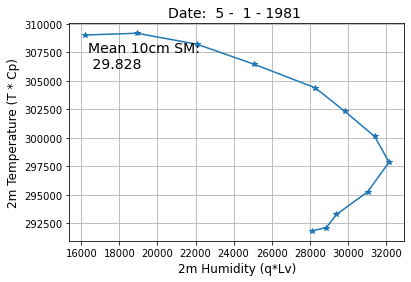

In [233]:
# Plot mixing diagram 
plt.plot(Q2m_energy,T2m_energy,'*-')
plt.title('Date: %2i - %2i - %4i ' % (atm_df_selMon_daytime['UTC_mon'][0], atm_df_selMon_daytime['UTC_day'][0], atm_df_selMon_daytime['UTC_yr'][0]), 
         fontsize=14)
plt.grid()
plt.xlabel('2m Humidity (q*Lv)',fontsize=12)
plt.ylabel('2m Temperature (T * Cp)', fontsize=12)

# Add mean SM amount to plot 
meanSM = np.nanmean(lnd_df_selMon_daytime[SM_name].values)
plt.text(np.min(Q2m_energy)*1.01,np.max(T2m_energy)*0.990, 'Mean 10cm SM:\n %.3f ' % meanSM, fontsize=14)

plt.show()



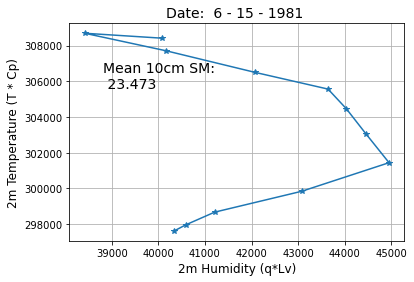

In [229]:
# Plot mixing diagram 
plt.plot(Q2m_energy,T2m_energy,'*-')
plt.title('Date: %2i - %2i - %4i ' % (atm_df_selMon_daytime['UTC_mon'][0], atm_df_selMon_daytime['UTC_day'][0], atm_df_selMon_daytime['UTC_yr'][0]), 
         fontsize=14)
plt.grid()
plt.xlabel('2m Humidity (q*Lv)',fontsize=12)
plt.ylabel('2m Temperature (T * Cp)', fontsize=12)

# Add mean SM amount to plot 
meanSM = np.nanmean(lnd_df_selMon_daytime[SM_name].values)
plt.text(np.min(Q2m_energy)*1.01,np.max(T2m_energy)*0.990, 'Mean 10cm SM:\n %.3f ' % meanSM, fontsize=14)

plt.show()


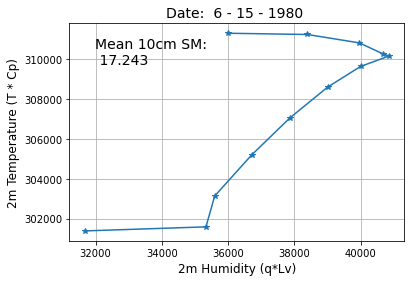

In [202]:
# Plot mixing diagram 
plt.plot(Q2m_energy,T2m_energy,'*-')
plt.title('Date: %2i - %2i - %4i ' % (atm_df_selMon_daytime['UTC_mon'][0], atm_df_selMon_daytime['UTC_day'][0], atm_df_selMon_daytime['UTC_yr'][0]), 
         fontsize=14)
plt.grid()
plt.xlabel('2m Humidity (q*Lv)',fontsize=12)
plt.ylabel('2m Temperature (T * Cp)', fontsize=12)

# Add mean SM amount to plot 
meanSM = np.nanmean(ldn_df_selMon_daytime[SM_name].values)
plt.text(np.min(Q2m_energy)*1.01,np.max(T2m_energy)*0.995, 'Mean 10cm SM:\n %.3f ' % meanSM, fontsize=14)

plt.show()

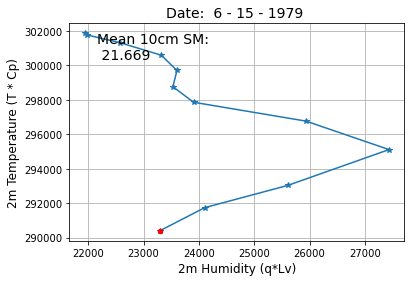

In [210]:
# Plot mixing diagram 
plt.plot(Q2m_energy,T2m_energy,'*-')
plt.plot(Q2m_energy[0],T2m_energy[0],'r.',markersize=9)  # 7a point 
plt.title('Date: %2i - %2i - %4i ' % (atm_df_selMon_daytime['UTC_mon'][0], atm_df_selMon_daytime['UTC_day'][0], atm_df_selMon_daytime['UTC_yr'][0]), 
         fontsize=14)
plt.grid()
plt.xlabel('2m Humidity (q*Lv)',fontsize=12)
plt.ylabel('2m Temperature (T * Cp)', fontsize=12)

# Add mean SM amount to plot 
meanSM = np.nanmean(ldn_df_selMon_daytime[SM_name].values)
plt.text(np.min(Q2m_energy)*1.01,np.max(T2m_energy)*0.995, 'Mean 10cm SM:\n %.3f ' % meanSM, fontsize=14)

plt.show()

**Can we get a *mean* June profile?**

In [253]:
# Going to pick out some random day in that period...
yrChoice  = 1980
monChoice = 6

iSel = np.where((atm_df_sel.UTC_mon==monChoice) & (atm_df_sel.UTC_yr.values==yrChoice))[0]

atm_df_selMon = atm_df_sel.isel(time=iSel)
lnd_df_selMon = lnd_df_sel.isel(time=iSel)

# For Oklahoma, 7a-7p is 12 UTC - 00 UTC 
iHrs = np.where(atm_df_selMon.UTC_hr.values>=12)[0]

atm_df_selMon_daytime = atm_df_selMon.isel(time=iHrs)
lnd_df_selMon_daytime = lnd_df_selMon.isel(time=iHrs)

# Convert to energy units for 2mT and 2mQ 

Lv = 2.5e6  # Latent heat of vaporization
Cp = 1005.7 # Specific heat capacity 

T2m_energy = atm_df_selMon_daytime[T2m_name].values * Cp
Q2m_energy = atm_df_selMon_daytime[Q2m_name].values * Lv

# Reshape to separate out days and hours... 
T2m_reshape = T2m_energy.reshape([30,12])
Q2m_reshape = Q2m_energy.reshape([30,12])

day_reshape = atm_df_selMon_daytime.UTC_day.values.reshape([30,12])

# To make sure that reshape worked, you can plot: 
# plt.plot(Q2m_energy[0:12],T2m_energy[0:12],'*-')
# plt.plot(Q2m_reshape[0,:],T2m_reshape[0,:],'k-')
# plt.grid()
# plt.xlabel('2m Humidity (q*Lv)',fontsize=12)
# plt.ylabel('2m Temperature (T * Cp)', fontsize=12)


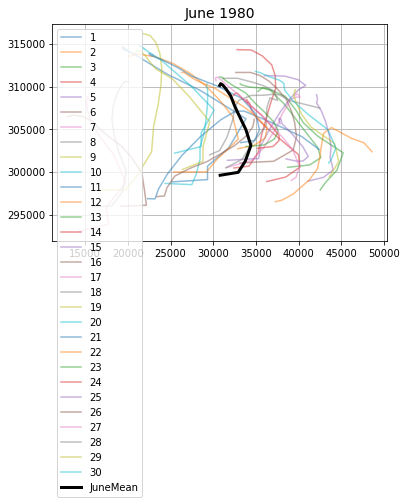

In [256]:
for iDay in range(30): 
    plt.plot(Q2m_reshape[iDay,:], T2m_reshape[iDay,:], alpha=0.5,label='%i' % day_reshape[iDay,0])
    
plt.plot(np.nanmean(Q2m_reshape,axis=0), np.nanmean(T2m_reshape,axis=0),'k',linewidth=3,label='JuneMean')
plt.title('June %i' % atm_df_selMon_daytime.UTC_yr[0],fontsize=14)
plt.grid()
plt.legend()

### Attempt to use coupling metrics toolbox. Solid no. 

In [145]:
# Use Ahmed's built in python version for this calculation first
cm.list_metrics


['CouplingIndex',
 'MixingDiagram',
 'HeatCond',
 'ConvTrig',
 'RHTend',
 'SoilMemory']

In [147]:
mixDiagram = cm.metrics.MixingDiagram()
mixDiagram = mixDiagram.compute(atm_df_sel,
                                averaging='month',
                                temp=T2m_name,
                                psfc=PS_name,
                                qhum=Q2m_name,
                                sh_flux=SH_name,
                                lh_flux=LH_name,
                                pblh=PBLH_name)

ValueError: Time dimension has irregular time interval...must be constant interval

In [135]:
dt = np.unique(atm_df_sel['time'].diff(dim='time').values.astype('timedelta64[s]'))
dt

array([ 3600, 90000], dtype='timedelta64[s]')

In [141]:
dt_1 = atm_df_sel['time'].diff(dim='time').values.astype('timedelta64[s]')
np.where(dt_1==np.max(dt_1))


(array([10175]),)

In [142]:
atm_df_sel.time.values[10173:10177]

array(['1980-02-28T21:00:00.000000000', '1980-02-28T22:00:00.000000000',
       '1980-02-28T23:00:00.000000000', '1980-03-01T00:00:00.000000000'],
      dtype='datetime64[ns]')